In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import csv

In [4]:
header_rows = 0
testdata = pd.read_csv('../data/testdata_10kSas.csv', skiprows=header_rows, nrows=25000)
testdata_time = pd.read_csv('../data/testdata_10kSas_timeregion.csv', skiprows=header_rows, nrows=25000)

# testdata_time2 = pd.read_csv('data/10(7).16/[1]X1&X2&X1-X2&X1+X2&SNL_timeregion.csv', skiprows=range(1, 25001), nrows=25000)

# testdata_time['P1'] = testdata_time2['X1']
# testdata_time['P2'] = testdata_time2['SNL']
# testdata_time['P1-P2'] = testdata_time2['X1-X2']
# testdata_time['P1+P2'] = testdata_time2['X2']

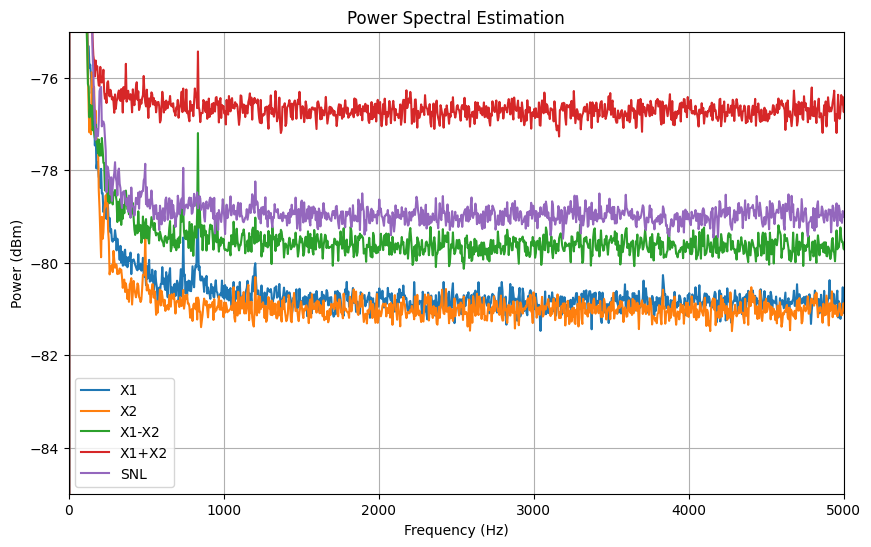

In [9]:
# Plot
yrange = 10
yref = -80
plt.figure(figsize=(10, 6))
plt.plot(testdata['Frequency'], testdata['X1(dBm)'], label='X1')
plt.plot(testdata['Frequency'], testdata['X2(dBm)'], label='X2')
plt.plot(testdata['Frequency'], testdata['X1-X2(dBm)'], label='X1-X2')
plt.plot(testdata['Frequency'], testdata['X1+X2(dBm)'], label='X1+X2')
plt.plot(testdata['Frequency'], testdata['SNL(dBm)'], label='SNL')

plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,5000)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
variances_raw = testdata_time.iloc[:, 1:].var()
# variances_raw = testdata_time.var()
# print(variances_raw)
# variances = variances_raw / variances_raw['SNL']
# print(variances)

# Adjust the dictionary to match the actual column names in variances_raw
variances_rawfix = pd.Series({
    'X1': variances_raw['X1'],
    'X2': variances_raw['SNL'],
    'X1+X2': variances_raw['X2'],
    'X1-X2': variances_raw['X1-X2'],
    'SNL': variances_raw['X1+X2'],
    "P1": variances_raw['P1'],
    "P2": variances_raw['P2'],
    "P1+P2": variances_raw['P1+P2'],
    "P1-P2": variances_raw['P1-P2'],
})
print(variances_rawfix)


variances = variances_rawfix / variances_rawfix['SNL']
print(variances)


X1       0.000056
X2       0.000063
X1+X2    0.000145
X1-X2    0.000070
SNL      0.000122
P1       0.000057
P2       0.000064
P1+P2    0.000146
P1-P2    0.000069
dtype: float64
X1       0.462662
X2       0.514707
X1+X2    1.189482
X1-X2    0.571655
SNL      1.000000
P1       0.466302
P2       0.522442
P1+P2    1.200653
P1-P2    0.564694
dtype: float64


In [23]:
matrix_qqpp = np.zeros((4, 4))
matrix_qpqp = np.zeros((4, 4))

matrix_qqpp[0, 0] = variances['X1']
matrix_qqpp[1, 1] = variances['X2']
matrix_qqpp[2, 2] = variances['P1']
matrix_qqpp[3, 3] = variances['P2']
matrix_qqpp[0, 1] = (variances['X1+X2'] - variances['X1'] - variances['X2'])/2
matrix_qqpp[1, 0] = matrix_qqpp[0, 1]
matrix_qqpp[2, 3] = (variances['P1+P2'] - variances['P1'] - variances['P2'])/2
matrix_qqpp[3, 2] = matrix_qqpp[2, 3]
print(matrix_qqpp)

matrix_qpqp[0, 0] = matrix_qqpp[0, 0]
matrix_qpqp[0, 1] = matrix_qqpp[0, 2]
matrix_qpqp[0, 2] = matrix_qqpp[0, 1]
matrix_qpqp[0, 3] = matrix_qqpp[0, 3]
matrix_qpqp[1, 0] = matrix_qqpp[2, 0]
matrix_qpqp[1, 1] = matrix_qqpp[2, 2]
matrix_qpqp[1, 2] = matrix_qqpp[2, 1]
matrix_qpqp[1, 3] = matrix_qqpp[2, 3]
matrix_qpqp[2, 0] = matrix_qqpp[1, 0]
matrix_qpqp[2, 1] = matrix_qqpp[1, 2]
matrix_qpqp[2, 2] = matrix_qqpp[1, 1]
matrix_qpqp[2, 3] = matrix_qqpp[1, 3]
matrix_qpqp[3, 0] = matrix_qqpp[3, 0]
matrix_qpqp[3, 1] = matrix_qqpp[3, 2]
matrix_qpqp[3, 2] = matrix_qqpp[3, 1]
matrix_qpqp[3, 3] = matrix_qqpp[3, 3]
print(matrix_qpqp)

[[0.46266207 0.10605644 0.         0.        ]
 [0.10605644 0.5147069  0.         0.        ]
 [0.         0.         0.46630224 0.10595436]
 [0.         0.         0.10595436 0.52244209]]
[[0.46266207 0.         0.10605644 0.        ]
 [0.         0.46630224 0.         0.10595436]
 [0.10605644 0.         0.5147069  0.        ]
 [0.         0.10595436 0.         0.52244209]]


In [28]:
def is_entangled(cov_matrix):
    """判断一个双模协方差矩阵是否符合 PPT 判据（是否纠缠）。
    
    参数：
    cov_matrix (np.ndarray): 4x4 的双模协方差矩阵。
    
    返回：
    bool: True 表示纠缠（不满足 PPT 判据），False 表示可分（满足 PPT 判据）。
    """
    # 辛矩阵
    Omega = np.array([[0, 1], [-1, 0]])
    Omega = np.kron(Omega, np.eye(2))
    
    P = np.diag([1, 1, 1, -1])
    
    # 计算 PPT 后的协方差矩阵
    cov_ppt = P @ cov_matrix @ P
    
    # 计算 (V_ppt + i * Omega) 的最小特征值
    symplectic_eigenvalues = np.linalg.eigvalsh(cov_ppt + 1j * Omega)
    min_eigenvalue = np.min(symplectic_eigenvalues)
    
    return min_eigenvalue < 0

# 检查该态是否纠缠
entangled = is_entangled(matrix_qpqp)
print(f"该量子态是否纠缠: {'是' if entangled else '否'}")

该量子态是否纠缠: 是
